In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F

import json
import re

import numpy as np

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install pymorphy2[fast]
# !pip3 install gensim
# !pip3 install torchtext

In [4]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

def normal_form(word):
    return morph.parse(word)[0].normal_form

In [5]:
# import pandas as pd

# df = pd.read_csv('../data/lenta-ru-news.csv')
# with open('../data/lenta-texts.json', 'w') as f:
#     json.dump([{'text':i} for i in df.title], f)

In [6]:
# with open('../data/lenta-texts.json', 'r') as f:
#     q = json.load(f)
# with open('../data/lenta-texts-small.json', 'w') as f:
#     json.dump(q[-10000:], f)

# with open('../data/lenta-texts-small.json', 'r') as f:
#     q = json.load(f)
# with open('../data/lenta-texts-small-val.json', 'w') as f:
#     json.dump(q[-100:], f)

# with open('../data/mem_big.json', 'r') as f:
#     q = json.load(f)
# print(len(q))
# with open('../data/mem-val.json', 'w') as f:
#     json.dump(q[-100:], f)


In [7]:
def preprocess(text):
    return ' '.join([normal_form(i) for i in re.findall(r'[А-я]+', text) if len(i) > 2])

In [8]:
import torchtext.vocab as vocab

vectors = vocab.Vectors('../data/ruwiki_20180420_100d.txt') # file created by gensim


In [10]:
PAD_IDX = len(vectors.stoi) - 2
UNK_IDX = len(vectors.stoi) - 1
TOTAL_EMBS = len(vectors)

In [11]:
def vectorize(text):
    text = preprocess(text['text'])
    inds = []
    if len(text.split()) < 5:
        return None
    for word in text.split():
        try:
            inds.append(vectors.stoi[word])
        except KeyError:
            inds.append(UNK_IDX)
    if len(inds) < 5:
        return None
    while len(inds) < 90:
        inds.append(PAD_IDX)
    return inds[:90]

In [12]:
def vectorize_all(texts):
    ans = []
    for text in tqdm_notebook(texts):
        try:
            vec = vectorize(text)
        except Exception as e:
            continue
        if vec:
            ans.append(vec)
    return ans

In [13]:
class FasttextSet(Dataset):
    def __init__(self, cosmo, nocosmo):
        '''
        data - json file name
        '''
        with open(nocosmo, 'r') as f:
            self.nocosmo = json.load(f)
        self.nocosmo = vectorize_all(self.nocosmo)

        with open(cosmo, 'r') as f:
            self.cosmo = json.load(f)
        self.cosmo = vectorize_all(self.cosmo)
    
    def __len__(self):
        return int(5e4)
    
    def __getitem__(self, ind):
        
        if ind%2 == 0:
            return torch.Tensor(self.cosmo[np.random.randint(len(self.cosmo))]).long(), \
                    torch.Tensor(self.cosmo[np.random.randint(len(self.cosmo))]).long(), 1
        return torch.Tensor(self.cosmo[np.random.randint(len(self.cosmo))]).long(), \
                torch.Tensor(self.nocosmo[np.random.randint(len(self.nocosmo))]).long(), 0


In [14]:
memLoader = DataLoader(FasttextSet('../data/mem_big.json', '../data/lenta-texts-small.json'),
                       batch_size=32, shuffle=True)

In [15]:
memLoader_val = DataLoader(FasttextSet('../data/mem-val.json', '../data/lenta-texts-small-val.json'),
                           batch_size=32, shuffle=True)

In [16]:
class SimilarityNet(nn.Module):
    def __init__(self, ):
        super(SimilarityNet, self).__init__()
        self.embs = nn.Embedding(len(vectors), embedding_dim=100, padding_idx=PAD_IDX).from_pretrained(
            torch.FloatTensor(vectors.vectors)
        )
        self.process = nn.Sequential(
            nn.Conv1d(100, 100, 15),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(0.05),
            nn.Conv1d(100, 64, 9),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.05),
        )
        
        self.compare = nn.Sequential(
            nn.Conv1d(128, 64, 9),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.05),
            nn.Conv1d(64, 32, 5),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.05),
            nn.Conv1d(32, 32, 5),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.05),
        )
        self.compare_fc = nn.Sequential(
            nn.Linear(32, 1),
#             nn.Sigmoid()
        )
        
    def forward(self, x1, x2):
        x1 = self.process(self.embs(x1).permute(0, 2, 1))
        x2 = self.process(self.embs(x2).permute(0, 2, 1))
        x = torch.cat([x1, x2], dim=1)
        x = self.compare(x)
        x = torch.mean(x, dim=-1)
        return self.compare_fc(x)

In [17]:
simnet = SimilarityNet()
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(simnet.parameters())

In [18]:
train_losses = []

for x1, x2, target in tqdm_notebook(memLoader):
    optim.zero_grad()
    pred = simnet(x1, x2)
    loss = criterion(pred, target.unsqueeze(1).float())
    train_losses.append(loss.item())
    loss.backward()
    optim.step()
    

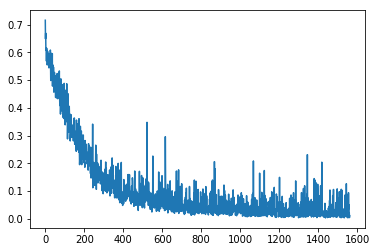

In [19]:
plt.plot(train_losses)

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


y_true = []
y_pred = []

for x1, x2, target in tqdm_notebook(memLoader_val):
    pred = simnet(x1, x2)
    for i, j in zip(pred.squeeze().detach().numpy(), target.detach().numpy()):
        y_pred.append(sigmoid(i))
        y_true.append(j)
        

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9982771936

In [22]:
with open('../data/mem-val.json', 'r') as f:
    c = json.load(f)
with open('../data/lenta-texts-small-val.json', 'r') as f:
    l = json.load(f)
    

In [38]:
l[50]

{'text': 'ФБР готовится к\xa0кибер-войне и\xa0терактам в\xa0канун 2000\xa0года'}

In [40]:
c[50]

{'text': 'отдел маркетинга #cosmopolitan_russia считает, что сегодня пятница!;)'}

In [30]:
def test_strs(x1, x2):
    x1 = torch.Tensor(vectorize(x1)).long().unsqueeze(0)
    x2 = torch.Tensor(vectorize(x2)).long().unsqueeze(0)
    ans = sigmoid(simnet(x1, x2).item())
    return ans

In [43]:
test_strs({'text' : 'Лавров ответил на публикацию разговора Трампа и Зеленского наставлением от мамы'},
          {'text' : 'Лавров ответил на публикацию разговора Трампа и Зеленского наставлением от мамы'})


0.5634875684116093

In [ ]:
simnet.parameters

In [30]:
simnet(batch[0], batch[1]).shape

torch.Size([32, 1])

In [37]:
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)


In [38]:
input

tensor([ 0.0399, -0.7024,  2.8633], requires_grad=True)

In [39]:
target

tensor([0., 0., 0.])